https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24 참조

In [1]:
import tensorflow as tf

In [2]:
from keras import backend as K
from keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.utils import plot_model

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import json

Using TensorFlow backend.


In [3]:
tf.__version__

'2.1.0'

# 1. Define loss & base network
- 두 가지 loss 함수
    - `triplet_loss`
        - 출처: https://thelonenutblog.wordpress.com/2017/12/18/what-siamese-dreams-are-made-of/
    - `lossless_triplet_loss`
        - 첫 epoch부터 loss가 nan으로 나옴 --> 해결 못함
        - 출처: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [4]:
def triplet_loss(y_true, y_pred, N=128, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, not used in this function.
    y_pred -- python list containing three objects:
            anchor:   the encodings for the anchor data
            positive: the encodings for the positive data (similar to anchor)
            negative: the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)))

    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)))

    # compute loss
    basic_loss = pos_dist-neg_dist + alpha

    loss = tf.maximum(basic_loss,0.0)

    return loss

In [5]:
def lossless_triplet_loss(y_true, y_pred, N=128, beta=128, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    
    return loss

In [6]:
def cnn_base_network(in_dims, out_dims):
    model = Sequential()

    model.add(Conv2D(input_shape = in_dims,
                     filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu'))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    #1차원화

    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(out_dims, activation = 'sigmoid'))

    return model

# 2. Load data

In [9]:
(x, y), (_, __) = tf.keras.datasets.fashion_mnist.load_data()
a, p, n = get_triplets(x, y, 5000)

In [10]:
a = np_preprocess(a)
p = np_preprocess(p)
n = np_preprocess(n)

In [11]:
a.shape

(5000, 28, 28, 1)

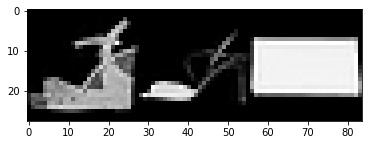

In [12]:
index = 0
plt.imshow(np.hstack([a[index, :, :, -1], p[index, :, :, -1], n[index, :, :, -1]]), cmap = 'gray')

In [8]:
# def prepare_mnist_features_and_labels(x, y):
#     x = tf.cast(x, tf.float32) / 255.0
#     y = tf.cast(y, tf.int64)
#     return x, y

def preprocess(x):
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.expand_dims(x, -1)    #흑백 이미지라 컬러 채널 강제로 추가
    return x

def np_preprocess(x):
    x = x.astype(np.float32) / 255.0
    x = np.expand_dims(x, -1)    #흑백 이미지라 컬러 채널 강제로 추가
    return x

def preprocess_inputs(d):
    a, p, n = d.values()
    a = preprocess(a)
    p = preprocess(p)
    n = preprocess(n)
    d['anchor'] = a
    d['positive'] = p
    d['negative'] = n
    return d

def get_triplets(x, y, sample_size):
    a = []
    p = []
    n = []
    
    num_classes = len(set(y))
    for _ in range(sample_size):
        num1, num2 = random.sample(range(num_classes), 2)
        positive_pool = x[np.where(y == num1)[0]]
        negative_pool = x[np.where(y == num2)[0]]
        num3, num4 = random.sample(range(len(positive_pool)), 2)

        anchor = positive_pool[num3]
        positive = positive_pool[num4]
        negative = negative_pool[random.randint(0, len(negative_pool)-1)]
        
        a.append(anchor)
        p.append(positive)
        n.append(negative)
        
    return np.asarray(a), np.asarray(p), np.asarray(n)

def mnist_train_dataset():
    (x, y), (_, __) = tf.keras.datasets.fashion_mnist.load_data()
    a, p, n = get_triplets(x, y, 300)
    ds = tf.data.Dataset.from_tensor_slices({"anchor": [a], "positive": [p], "negative": [n]})
    ds = ds.map(preprocess_inputs)
#     ds = ds.take(20000).shuffle(20000).batch(100)
    return ds

def mnist_test_dataset():
    (_, __), (x, y) = tf.keras.datasets.fashion_mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    return ds

#train_dataset = mnist_train_dataset()
# test_dataset = mnist_test_dataset()

In [12]:
batch_size = len(list(train_dataset.as_numpy_iterator()))

In [13]:
y_dummie = np.zeros(batch_size)

In [14]:
img_size = list(train_dataset.as_numpy_iterator())[0]['anchor'].shape

In [15]:
img_size

(300, 28, 28, 1)

# 3. Create model

In [13]:
in_dims = (a.shape[1], a.shape[2], a.shape[3])    # (28, 28, 1)
out_dims = 128

# Create the 3 inputs
anchor_in = Input(shape=in_dims, name='anchor')
pos_in = Input(shape=in_dims, name='positive')
neg_in = Input(shape=in_dims, name='negative')

# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = cnn_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)

# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=lossless_triplet_loss)

In [14]:
base_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        5824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 32)         

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          66628       anchor[0][0]                     
                                                                 positive[0][0]             

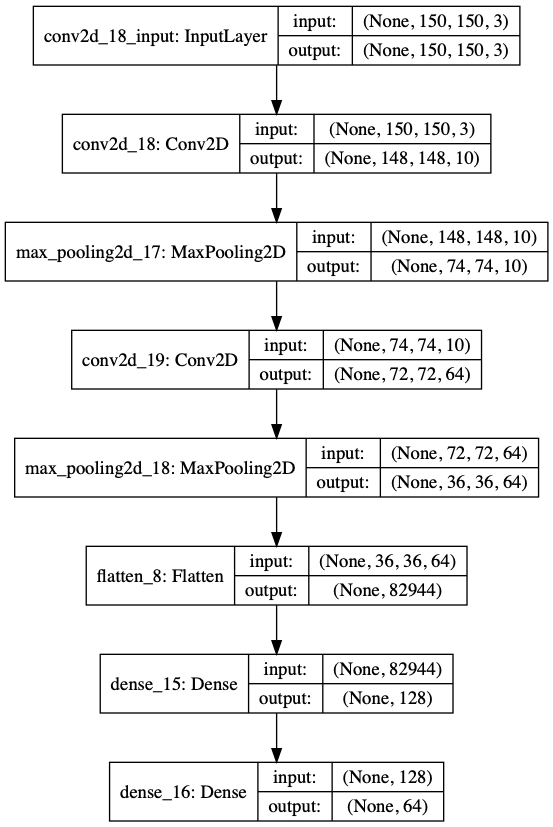

In [283]:
plot_model(base_network, to_file='./CNN/base_network.png', show_shapes=True, show_layer_names=True)

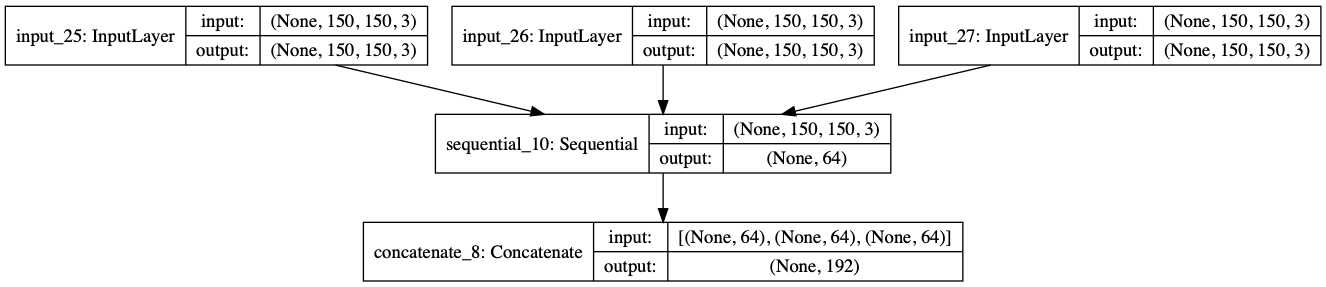

In [75]:
plot_model(model, to_file='./CNN/cnn_model.png', show_shapes=True, show_layer_names=True)

# 4. Train

In [16]:
y_dummie = np.zeros(a.shape[0])

In [17]:
# Training the model
H = model.fit([a, p, n], y_dummie, epochs=15)

Epoch 1/15
5000/5000 [==============================] - 20s 4ms/step - loss: 8.5251
Epoch 2/15
5000/5000 [==============================] - 20s 4ms/step - loss: 3.5139
Epoch 3/15
5000/5000 [==============================] - 20s 4ms/step - loss: 2.3884
Epoch 4/15
5000/5000 [==============================] - 19s 4ms/step - loss: 1.9208
Epoch 5/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.6923
Epoch 6/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.5542
Epoch 7/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.4649
Epoch 8/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.4043
Epoch 9/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.3542
Epoch 10/15
5000/5000 [==============================] - 19s 4ms/step - loss: 1.3166
Epoch 11/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.2868
Epoch 12/15
5000/5000 [==============================] - 18s 4ms/step - lo

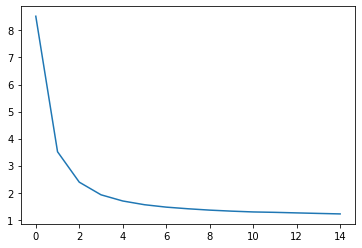

In [18]:
#결과 확인
plt.plot(H.history['loss'])
# plt.savefig('./CNN/loss_graph.png')
# plt.legend(['loss'], loc = 'upper left')
plt.show()

# 5. Save model & weights

In [19]:
model_dir = './trained/lossless_triplet.json'
model_weights_dir = './trained/lossless_triplet.h5'

In [20]:
#Save model
model_json = model.to_json()
with open(model_dir, "w") as json_file : 
    json_file.write(model_json)

#Save weights
model.save_weights(model_weights_dir)
print("Saved model to disk")

Saved model to disk


In [ ]:
#Load model & weights
from keras.models import model_from_json
json_file = open(model_dir, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_weights_dir)
print("Loaded model from disk")

# 6. Application

In [21]:
def item_to_encoding(item, model):
    return model.predict(np.array([item]))

## 7.1 Load test data

In [22]:
(_, __), (x, y) = tf.keras.datasets.fashion_mnist.load_data()

sample_size = 1000
t_a, t_p, t_n = get_triplets(x, y, sample_size)
t_a = np_preprocess(t_a)
t_p = np_preprocess(t_p)
t_n = np_preprocess(t_n)

In [23]:
x.shape

(10000, 28, 28)

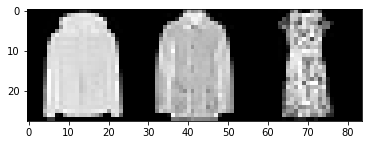

In [24]:
index = 0
plt.imshow(np.hstack([t_a[index, :, :, -1], t_p[index, :, :, -1], t_n[index, :, :, -1]]), cmap = 'gray')

---------- wrong embedding : index 6 -----------


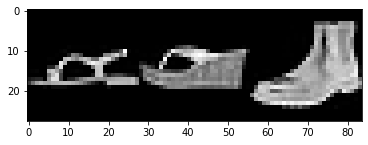

---------- wrong embedding : index 10 -----------


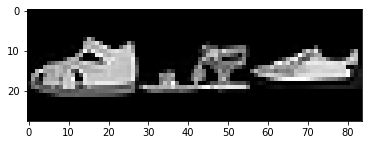

---------- wrong embedding : index 12 -----------


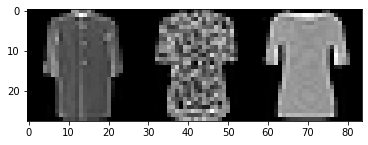

---------- wrong embedding : index 15 -----------


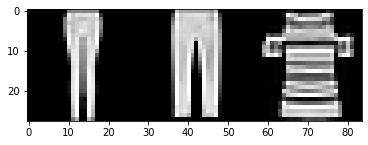

---------- wrong embedding : index 22 -----------


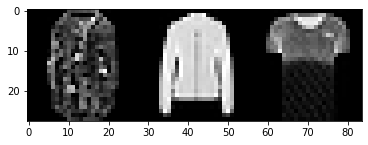

---------- wrong embedding : index 23 -----------


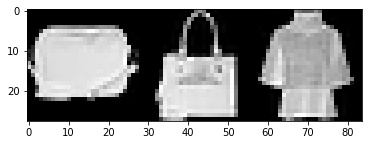

---------- wrong embedding : index 24 -----------


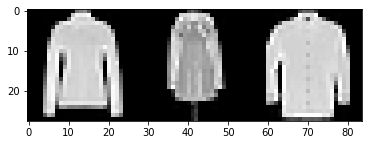

---------- wrong embedding : index 26 -----------


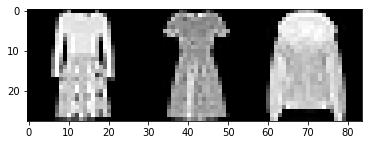

---------- wrong embedding : index 27 -----------


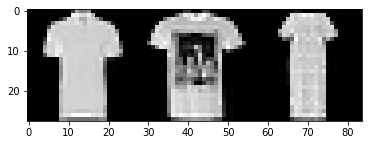

---------- wrong embedding : index 30 -----------


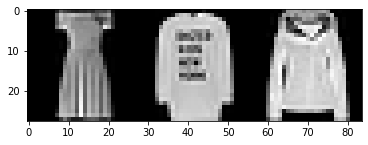

---------- wrong embedding : index 31 -----------


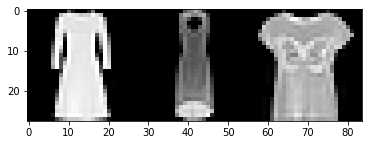

---------- wrong embedding : index 42 -----------


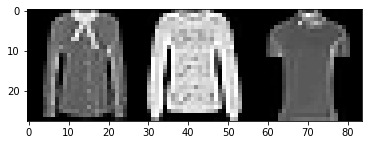

---------- wrong embedding : index 48 -----------


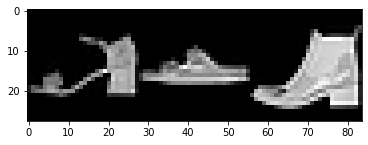

---------- wrong embedding : index 58 -----------


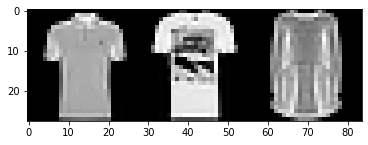

---------- wrong embedding : index 67 -----------


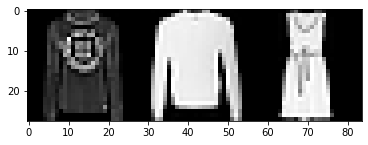

---------- wrong embedding : index 69 -----------


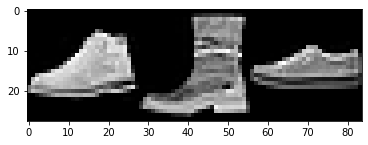

---------- wrong embedding : index 70 -----------


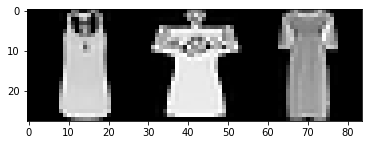

---------- wrong embedding : index 71 -----------


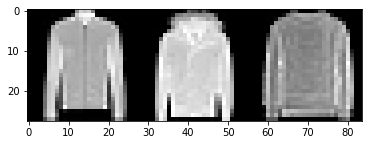

---------- wrong embedding : index 80 -----------


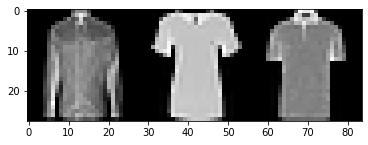

---------- wrong embedding : index 88 -----------


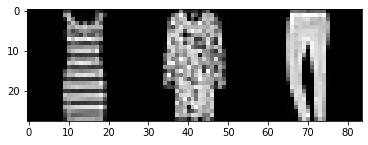

---------- wrong embedding : index 117 -----------


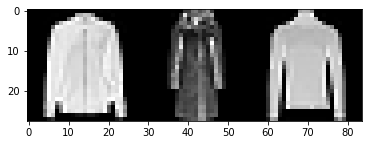

---------- wrong embedding : index 129 -----------


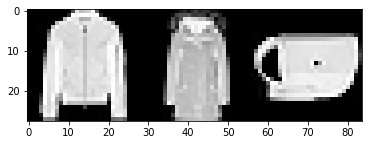

---------- wrong embedding : index 164 -----------


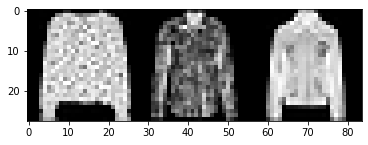

---------- wrong embedding : index 176 -----------


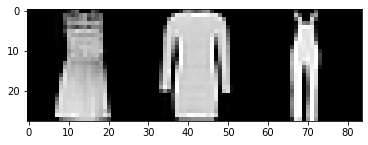

---------- wrong embedding : index 186 -----------


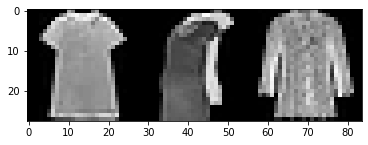

---------- wrong embedding : index 189 -----------


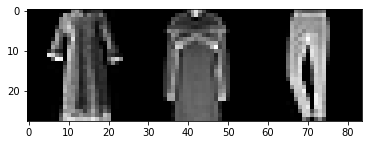

---------- wrong embedding : index 202 -----------


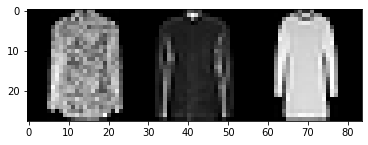

---------- wrong embedding : index 221 -----------


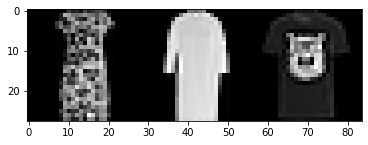

---------- wrong embedding : index 225 -----------


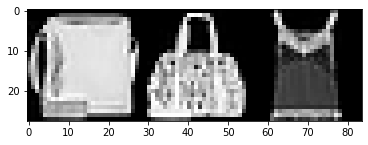

---------- wrong embedding : index 226 -----------


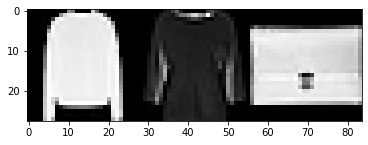

---------- wrong embedding : index 230 -----------


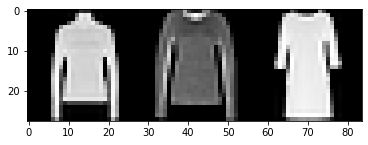

---------- wrong embedding : index 232 -----------


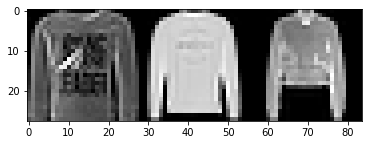

---------- wrong embedding : index 243 -----------


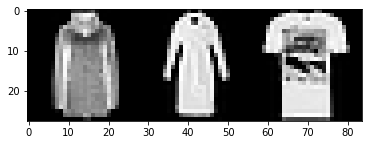

---------- wrong embedding : index 249 -----------


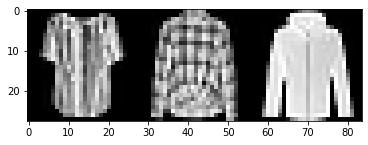

---------- wrong embedding : index 259 -----------


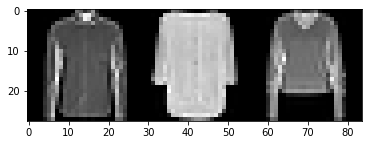

---------- wrong embedding : index 262 -----------


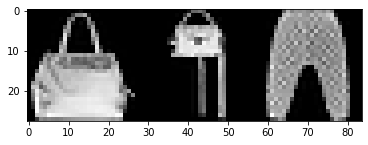

---------- wrong embedding : index 265 -----------


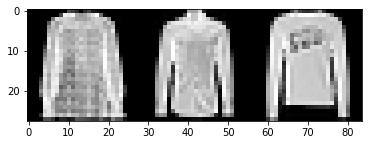

---------- wrong embedding : index 267 -----------


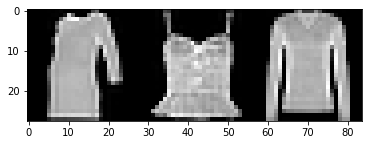

---------- wrong embedding : index 276 -----------


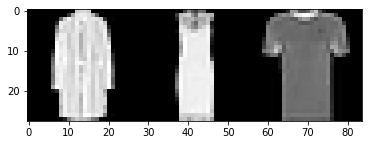

---------- wrong embedding : index 277 -----------


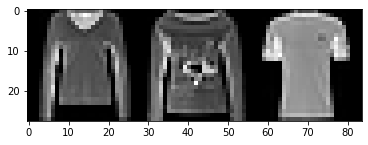

---------- wrong embedding : index 283 -----------


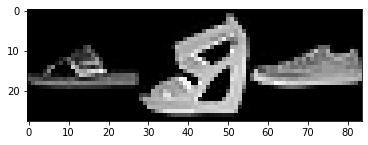

---------- wrong embedding : index 286 -----------


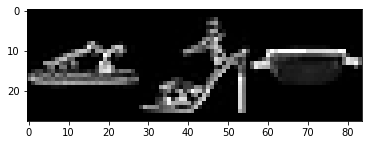

---------- wrong embedding : index 297 -----------


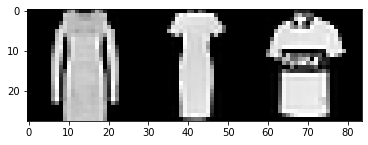

---------- wrong embedding : index 308 -----------


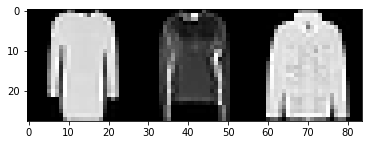

---------- wrong embedding : index 311 -----------


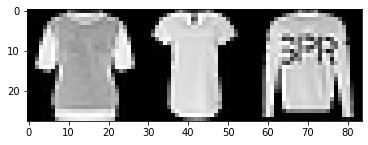

---------- wrong embedding : index 313 -----------


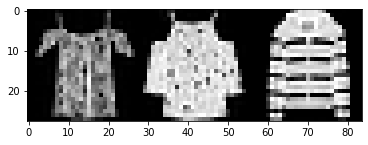

---------- wrong embedding : index 319 -----------


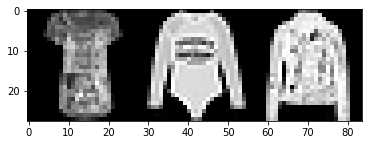

---------- wrong embedding : index 331 -----------


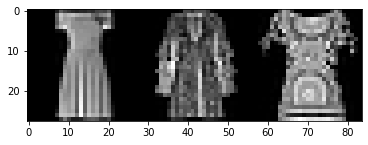

---------- wrong embedding : index 333 -----------


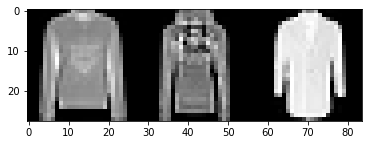

---------- wrong embedding : index 338 -----------


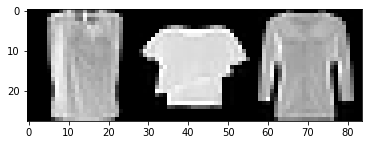

---------- wrong embedding : index 341 -----------


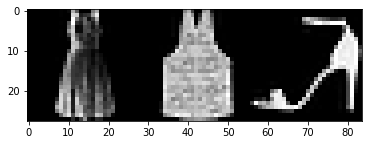

---------- wrong embedding : index 343 -----------


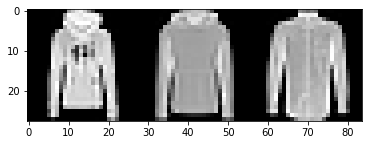

---------- wrong embedding : index 346 -----------


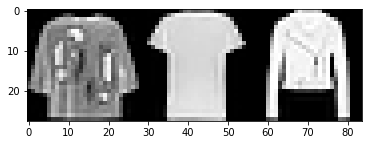

---------- wrong embedding : index 353 -----------


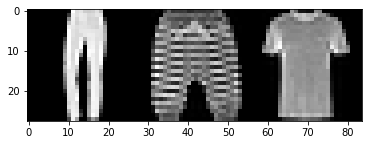

---------- wrong embedding : index 369 -----------


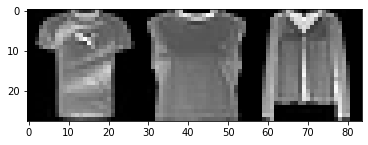

---------- wrong embedding : index 371 -----------


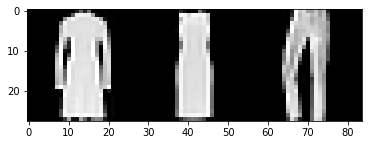

---------- wrong embedding : index 375 -----------


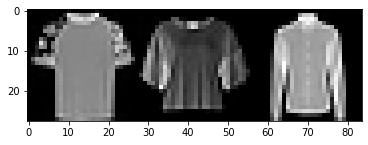

---------- wrong embedding : index 403 -----------


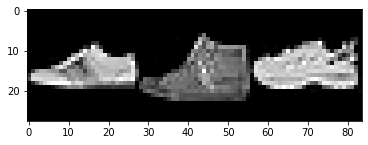

---------- wrong embedding : index 412 -----------


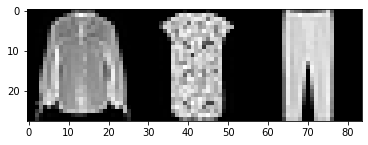

---------- wrong embedding : index 427 -----------


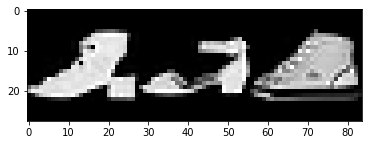

---------- wrong embedding : index 441 -----------


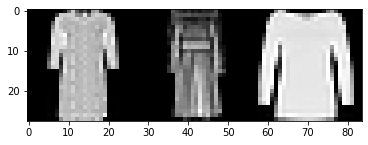

---------- wrong embedding : index 444 -----------


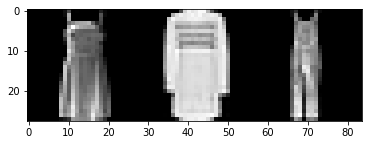

---------- wrong embedding : index 450 -----------


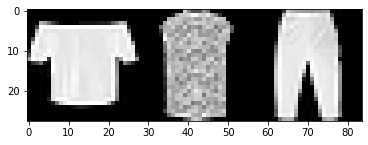

---------- wrong embedding : index 453 -----------


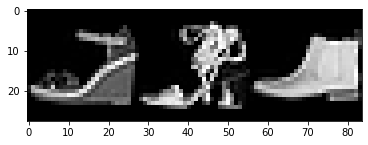

---------- wrong embedding : index 472 -----------


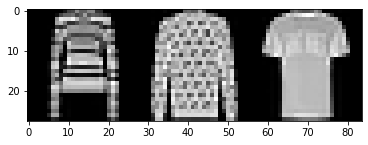

---------- wrong embedding : index 478 -----------


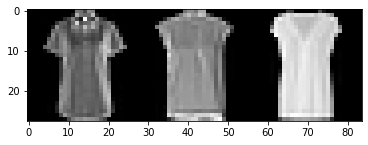

---------- wrong embedding : index 482 -----------


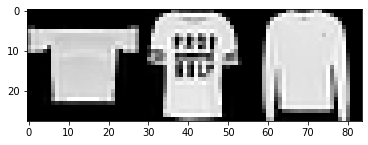

---------- wrong embedding : index 489 -----------


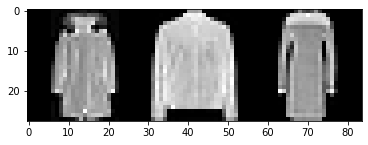

---------- wrong embedding : index 499 -----------


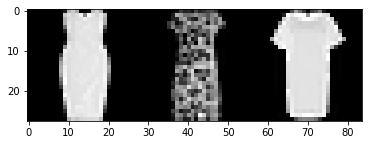

---------- wrong embedding : index 500 -----------


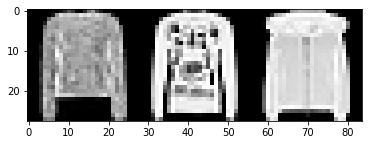

---------- wrong embedding : index 514 -----------


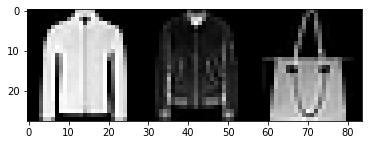

---------- wrong embedding : index 516 -----------


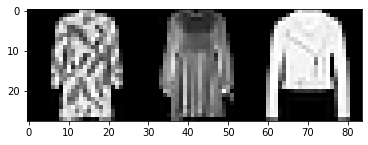

---------- wrong embedding : index 533 -----------


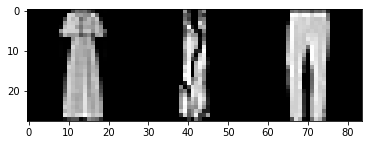

---------- wrong embedding : index 540 -----------


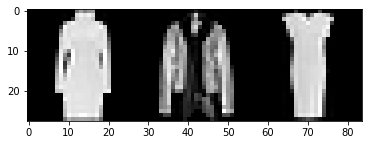

---------- wrong embedding : index 542 -----------


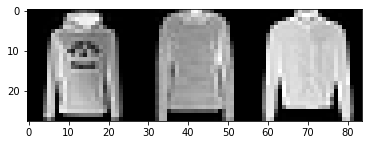

---------- wrong embedding : index 545 -----------


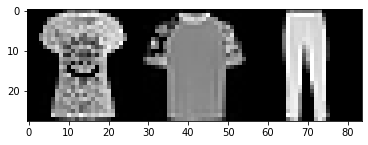

---------- wrong embedding : index 546 -----------


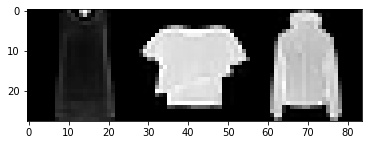

---------- wrong embedding : index 557 -----------


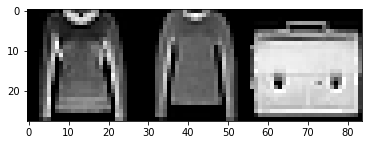

---------- wrong embedding : index 574 -----------


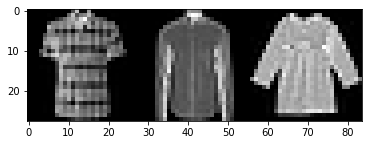

---------- wrong embedding : index 575 -----------


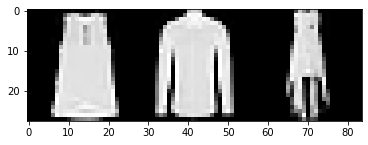

---------- wrong embedding : index 579 -----------


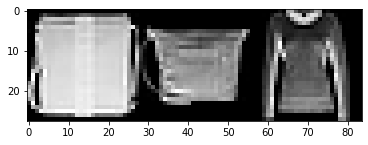

---------- wrong embedding : index 603 -----------


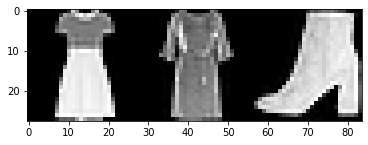

---------- wrong embedding : index 607 -----------


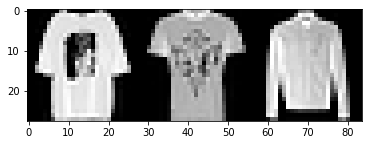

---------- wrong embedding : index 632 -----------


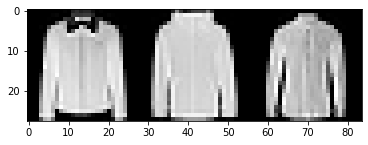

---------- wrong embedding : index 634 -----------


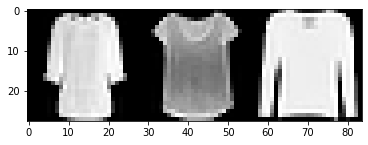

---------- wrong embedding : index 637 -----------


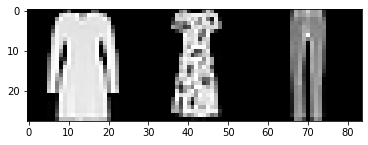

---------- wrong embedding : index 645 -----------


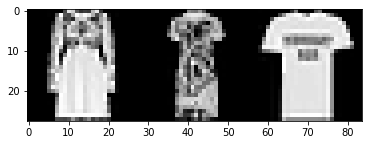

---------- wrong embedding : index 653 -----------


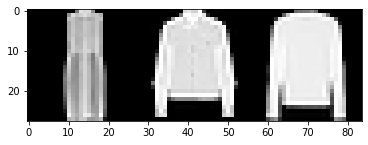

---------- wrong embedding : index 656 -----------


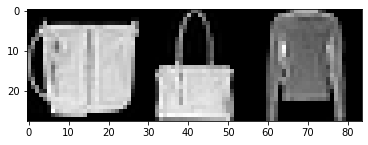

---------- wrong embedding : index 679 -----------


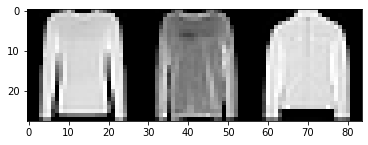

---------- wrong embedding : index 680 -----------


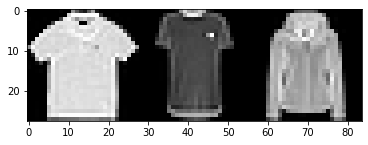

---------- wrong embedding : index 681 -----------


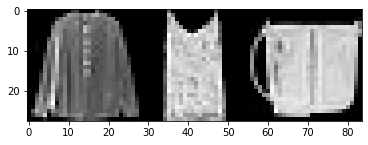

---------- wrong embedding : index 683 -----------


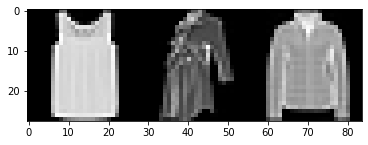

---------- wrong embedding : index 692 -----------


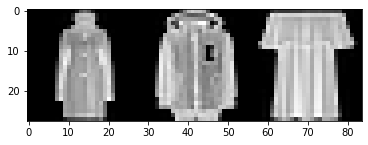

---------- wrong embedding : index 717 -----------


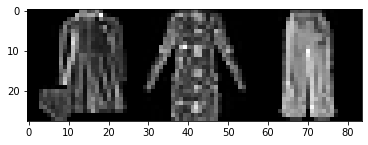

---------- wrong embedding : index 725 -----------


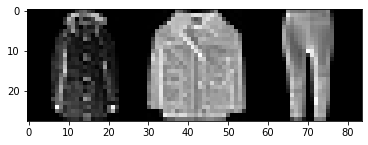

---------- wrong embedding : index 726 -----------


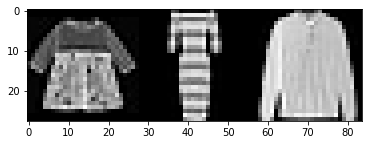

---------- wrong embedding : index 729 -----------


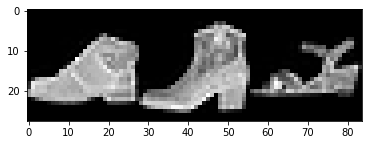

---------- wrong embedding : index 730 -----------


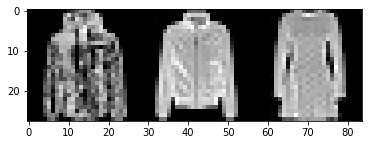

---------- wrong embedding : index 740 -----------


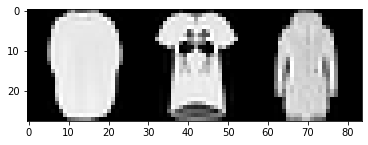

---------- wrong embedding : index 760 -----------


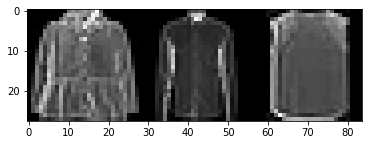

---------- wrong embedding : index 773 -----------


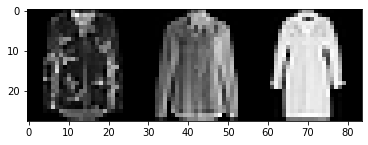

---------- wrong embedding : index 793 -----------


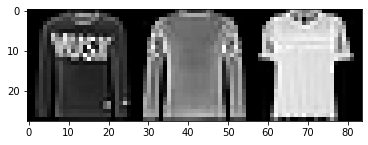

---------- wrong embedding : index 798 -----------


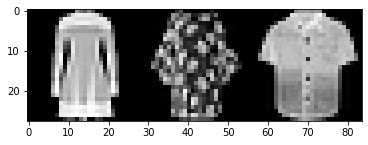

---------- wrong embedding : index 809 -----------


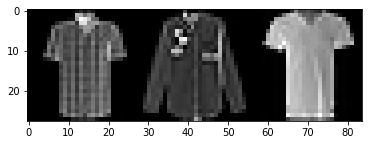

---------- wrong embedding : index 810 -----------


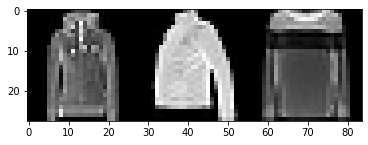

---------- wrong embedding : index 814 -----------


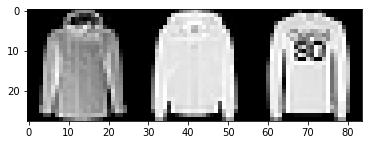

---------- wrong embedding : index 818 -----------


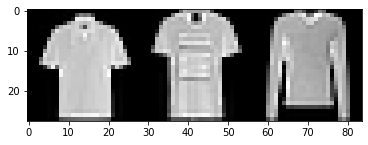

---------- wrong embedding : index 830 -----------


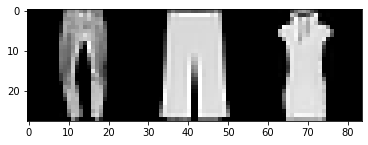

---------- wrong embedding : index 842 -----------


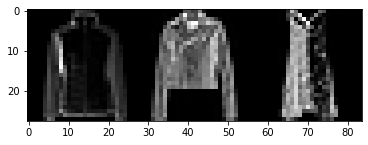

---------- wrong embedding : index 845 -----------


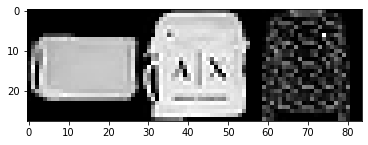

---------- wrong embedding : index 856 -----------


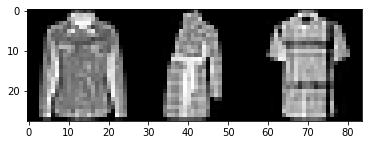

---------- wrong embedding : index 860 -----------


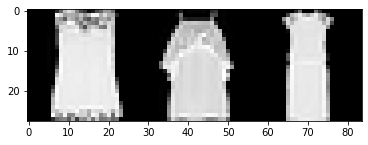

---------- wrong embedding : index 866 -----------


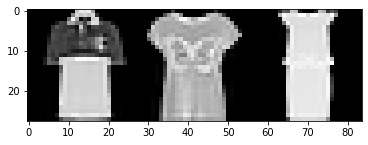

---------- wrong embedding : index 876 -----------


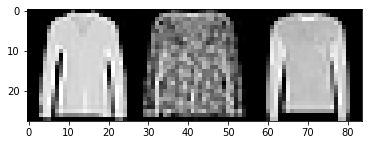

---------- wrong embedding : index 878 -----------


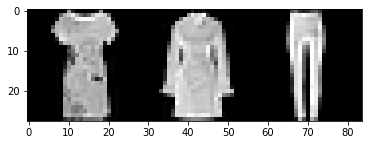

---------- wrong embedding : index 887 -----------


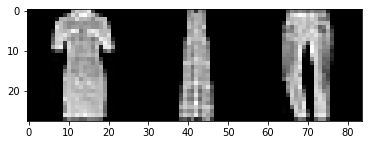

---------- wrong embedding : index 890 -----------


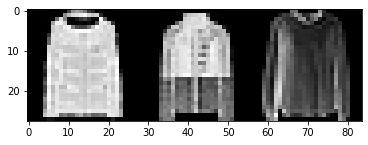

---------- wrong embedding : index 898 -----------


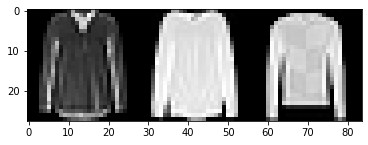

---------- wrong embedding : index 902 -----------


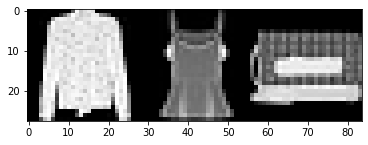

---------- wrong embedding : index 908 -----------


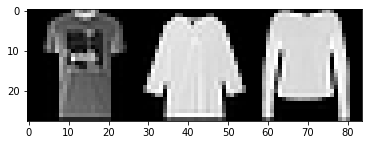

---------- wrong embedding : index 910 -----------


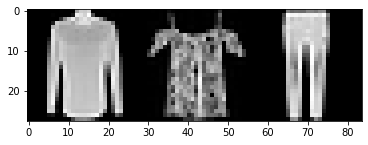

---------- wrong embedding : index 912 -----------


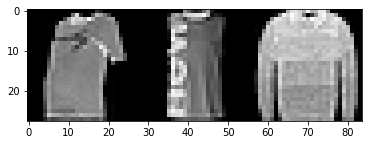

---------- wrong embedding : index 927 -----------


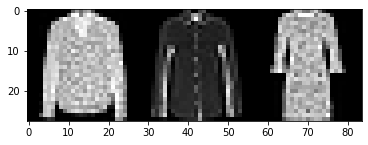

---------- wrong embedding : index 928 -----------


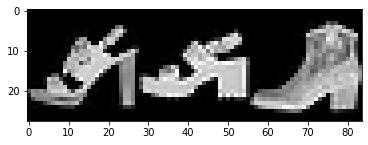

---------- wrong embedding : index 933 -----------


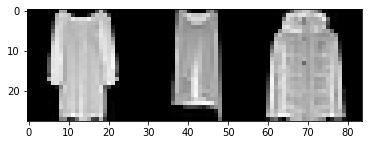

---------- wrong embedding : index 940 -----------


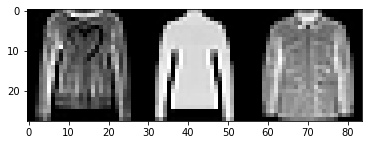

---------- wrong embedding : index 945 -----------


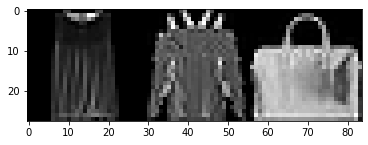

---------- wrong embedding : index 951 -----------


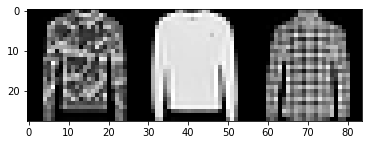

---------- wrong embedding : index 965 -----------


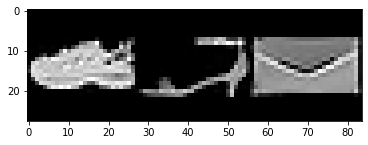

---------- wrong embedding : index 976 -----------


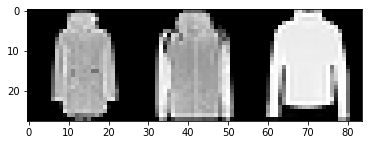

---------- wrong embedding : index 986 -----------


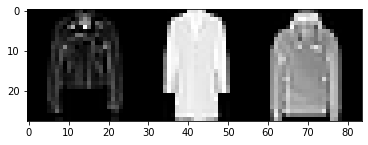

---------- wrong embedding : index 995 -----------


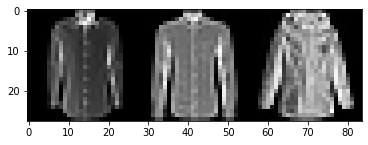

---------- wrong embedding : index 996 -----------


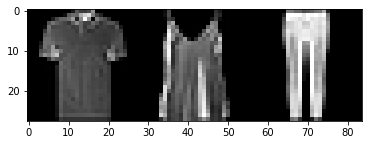

true: 866 false: 134
Accuracy: 0.866


In [25]:
count_true = 0
for k in range(sample_size):
    anchor_encoding = item_to_encoding(t_a[k], base_network)
    pos_encoding = item_to_encoding(t_p[k], base_network)
    neg_encoding = item_to_encoding(t_n[k], base_network)

    anchor_pos_dist = np.linalg.norm(anchor_encoding-pos_encoding)
    anchor_neg_dist = np.linalg.norm(anchor_encoding-neg_encoding)

    cond = anchor_pos_dist < anchor_neg_dist
    
    if cond: count_true += 1
        
    else: 
        print('---------- wrong embedding : index %d -----------'%k)
        plt.imshow(np.hstack([t_a[k, :, :, -1], t_p[k, :, :, -1], t_n[k, :, :, -1]]), cmap = 'gray')
        plt.show()
        
print("true: {} false: {}".format(count_true, sample_size-count_true))
print("Accuracy: {}".format(count_true / sample_size))

# 6. seoulstore

In [40]:
def load_items(folder):
    items = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        items.append(img)
    return items

In [41]:
item_dir = '../../img/seoulstore_mini/'

items = load_items(item_dir)

In [42]:
len(items)

381

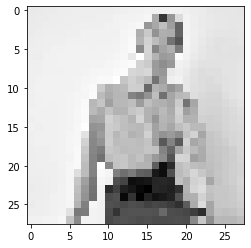

In [43]:
plt.imshow(items[0], cmap = 'gray')

In [45]:
thresh = 4

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(items[:10]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(items[0], cmap = 'gray')
plt.xlabel("Anchor", fontsize=80)

anchor_encoding = item_to_encoding(np.expand_dims(items[0], -1), base_network)

for k in range(len(items[:10])):        
    i = items[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(np.expand_dims(i, -1), base_network)
    dist = np.linalg.norm(anchor_encoding-item_encoding)
    c =  "blue" if  dist < thresh  else "red"
    plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = c, fontsize=80)

In [99]:
# create encoding database with insta images
database = {}

for k in range(len(images)):
    if database.get(labels_eng[labels[k]]) != None:
        database[labels_eng[labels[k]]].append(item_to_encoding(images[k], base_network))
    else:
        database[labels_eng[labels[k]]] = [item_to_encoding(images[k], base_network)]

In [125]:
# Prediction on item
similar_styles = identify_item(items[0], database, base_network, 0.03)
similar_styles

{'uau__shop': 0.026308946,
 'marhenbreeze_official': 0.02979614,
 '_noncode_': 0.024152417,
 'angelic_co_': 0.029026119,
 'beigee_au': 0.024907574}

In [ ]:
plt.figure(figsize=(60, 60))

cc = 3
rr = int(len(similar_styles) / cc)+1

plt.subplot(rr ,cc, 1)
plt.imshow(items[0], cmap = 'gray')
plt.xlabel("item", fontsize=80)

count = 0

for k in range(len(images)): 
    image = images[k]
    image_encoding = item_to_encoding(image, base_network)  
    dist = np.linalg.norm(image_encoding-item_encoding) 
    if dist < 0.03:
        count += 1
        num_label = labels[k]
        eng_label = labels_dict[num_label]
        plt.subplot( rr ,cc, count+1)   # 몇 칼럼 몇 로우에 그래프 그릴지
        plt.imshow(image)
        plt.xlabel("{}, distance from item: {:.2f}".format(eng_label, dist),fontsize=50)       

## 7.2 Tag items

### 7.2.1 Load original json file to append data

In [173]:
# load original json file
with open(json_path, "r", encoding="utf8") as f:
    url_data = json.load(f, encoding = 'utf-8')

In [ ]:
# reformat original json file
count = 0
for data in url_data:
    data['product_url'] = data['key']
    data['key'] = '{:03d}'.format(count)
    count += 1

In [180]:
url_data

[{'img_url': 'https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1034006/detail',
  'key': '000'},
 {'img_url': 'https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1033985/detail',
  'key': '001'},
 {'img_url': 'https://images.seoulstore.com/products/7a1290b26d9d97727fed159c3dcd9787.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1156713/detail',
  'key': '002'},
 {'img_url': 'https://images.seoulstore.com/products/f18808eb779908fac372ef1889d9305e.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1157389/detail',
  'key': '003'},
 {'img_url': 'https://images.seoulstore.com/products/873051287385fff1f4a0bb730b677691.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1178983/detail',
  'key': '004'},
 {'img_url': 'https://images.seoulstore.com/p

In [238]:
sorted_items_dict = dict(sorted(items_dict.items()))

In [239]:
sorted_items_dict

{'000': array([[[186, 171, 137],
         [187, 172, 139],
         [187, 172, 139],
         ...,
         [ 65,  52,  41],
         [ 86,  69,  56],
         [ 39,  19,  10]],
 
        [[187, 172, 139],
         [188, 173, 140],
         [191, 176, 143],
         ...,
         [ 40,  30,  19],
         [ 37,  26,  17],
         [ 34,  21,  14]],
 
        [[182, 167, 134],
         [189, 174, 141],
         [191, 176, 143],
         ...,
         [105,  94,  74],
         [ 68,  55,  46],
         [ 35,  25,  21]],
 
        ...,
 
        [[177, 161, 128],
         [181, 165, 132],
         [181, 164, 131],
         ...,
         [ 11,  11,  11],
         [ 12,  12,  12],
         [ 11,  11,  11]],
 
        [[183, 167, 134],
         [184, 168, 135],
         [183, 167, 134],
         ...,
         [ 13,  13,  13],
         [ 12,  12,  12],
         [ 12,  12,  12]],
 
        [[180, 163, 131],
         [181, 165, 132],
         [183, 167, 134],
         ...,
         [ 11,  11,  

In [240]:
len(sorted_items_dict) == len(url_data)

True

In [241]:
keys_list = list(sorted_items_dict.keys())

In [242]:
for k in range(len(keys_list)):
    print( keys_list[k] == url_data[k]['key'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [278]:
for k in range(len(keys_list)):
    key = keys_list[k]
    similar_styles = identify_item(items_dict[key]/255., database, base_network, 0.05)
#     print( similar_styles != {} )
    if key == url_data[k]['key']:
        url_data[k]['likely'] = similar_styles

In [279]:
url_data

[{'img_url': 'https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1034006/detail',
  'key': '000',
  'likely': {'januaryrose_insta': '0.046844076',
   'and_more_seoul': '0.049897134'}},
 {'img_url': 'https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1033985/detail',
  'key': '001',
  'likely': {'korean_styless_': '0.03981472',
   'asyoulikeit_shop': '0.04885481',
   'uau__shop': '0.0454914',
   'rosemelon.kr': '0.048884925',
   'someday__s': '0.0331893',
   'j_blin': '0.04953617',
   'jessavintage': '0.044505827',
   '_daisyys': '0.044975378',
   'maysome_official': '0.045360528',
   '4x2a': '0.043121725',
   'mori__closet': '0.046707377',
   'andsimpleofficial': '0.0371679',
   'and_more_seoul': '0.04784448',
   'marhenbreeze_official': '0.032038815',
   'myojaeng': '0.039229285',
   'bigking0720': '0.03

## 7.3 Save result as json

In [280]:
def output(data, filepath):
    out = json.dumps(data, ensure_ascii=False)
    if filepath:
        with open(filepath, "a", encoding="utf8") as f:
            f.write(out)
            print("successfully saved file")
    else:
        with open(filepath, "w", encoding="utf8") as f:
            f.write(out)
    return out

In [281]:
filepath = './seoulstore_tagged_05.json'

out = output(url_data, filepath)

successfully saved file


In [282]:
parsed = json.loads(out)
print(json.dumps(parsed, indent=4, sort_keys=True))

[
    {
        "img_url": "https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto",
        "key": "000",
        "likely": {
            "and_more_seoul": "0.049897134",
            "januaryrose_insta": "0.046844076"
        },
        "product_url": "https://www.seoulstore.com/products/1034006/detail"
    },
    {
        "img_url": "https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto",
        "key": "001",
        "likely": {
            "0.94k": "0.03616242",
            "4x2a": "0.043121725",
            "_daisyys": "0.044975378",
            "_noncode_": "0.04005536",
            "acubi_club": "0.04790125",
            "aestheticssoul_": "0.03442119",
            "and_more_seoul": "0.04784448",
            "andsimpleofficial": "0.0371679",
            "angelic_co_": "0.04440499",
            "arif.house": "0.048768602",
            "asyoulikeit_shop": "0.04885481",
            "beigee_au": "0.033273064",
       